# Quiz 3

In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Давайте проанализируем данные опроса 4361 женщин из Ботсваны:

О каждой из них мы знаем:

    сколько детей она родила (признак ceb)

    возраст (age)

    длительность получения образования (educ)

    религиозная принадлежность (religion)

    идеальное, по её мнению, количество детей в семье (idlnchld)

    была ли она когда-нибудь замужем (evermarr)

    возраст первого замужества (agefm)

    длительность получения образования мужем (heduc)

    знает ли она о методах контрацепции (knowmeth)

    использует ли она методы контрацепции (usemeth)

    живёт ли она в городе (urban)

    есть ли у неё электричество, радио, телевизор и велосипед (electric, radio, tv, bicycle)

Давайте научимся оценивать количество детей ceb по остальным признакам.

##  Question 1

Загрузите данные и внимательно изучите их. Сколько разных значений принимает признак religion?

In [3]:
df = pd.read_csv("botswana.tsv", sep ='\t')
df.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4361 entries, 0 to 4360
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ceb       4361 non-null   int64  
 1   age       4361 non-null   int64  
 2   educ      4361 non-null   int64  
 3   religion  4361 non-null   object 
 4   idlnchld  4241 non-null   float64
 5   knowmeth  4354 non-null   float64
 6   usemeth   4290 non-null   float64
 7   evermarr  4361 non-null   int64  
 8   agefm     2079 non-null   float64
 9   heduc     1956 non-null   float64
 10  urban     4361 non-null   int64  
 11  electric  4358 non-null   float64
 12  radio     4359 non-null   float64
 13  tv        4359 non-null   float64
 14  bicycle   4358 non-null   float64
dtypes: float64(9), int64(5), object(1)
memory usage: 511.2+ KB


In [5]:
df.religion.nunique()

4

## Question 2

Во многих признаках есть пропущенные значения. Сколько объектов из 4361 останется, если выбросить все, содержащие пропуски? 

In [6]:
df.isnull().mean()

ceb         0.000000
age         0.000000
educ        0.000000
religion    0.000000
idlnchld    0.027517
knowmeth    0.001605
usemeth     0.016281
evermarr    0.000000
agefm       0.523274
heduc       0.551479
urban       0.000000
electric    0.000688
radio       0.000459
tv          0.000459
bicycle     0.000688
dtype: float64

In [7]:
len(df), len(df.dropna(axis=0))

(4361, 1834)

##  Question 3


В разных признаках пропуски возникают по разным причинам и должны обрабатываться по-разному.

Например, в признаке agefm пропуски стоят только там, где evermarr=0, то есть, они соответствуют женщинам, никогда не выходившим замуж. Таким образом, для этого признака NaN соответствует значению "не применимо".

В подобных случаях, когда признак x1 на части объектов в принципе не может принимать никакие значения, рекомендуется поступать так:

создать новый бинарный признак x2={1,0,x1='не применимо',иначе; заменить "не применимо" в x1 на произвольную константу c, которая среди других значений x1 не встречается. Теперь, когда мы построим регрессию на оба признака и получим модель вида y=β0+β1x1+β2x2, на тех объектах, где x1 было измерено, регрессионное уравнение примет вид y=β0+β1x, а там, где x1 было "не применимо", получится y=β0+β1c+β2. Выбор c влияет только на значение и интерпретацию β2, но не β1.

Давайте используем этот метод для обработки пропусков в agefm и heduc.

Сколько осталось пропущенных значений в признаке heduc?

In [8]:
#df.agefm.value_counts()

In [9]:
df.agefm.unique()

array([nan, 20., 22., 24., 15., 26., 18., 23., 21., 25., 17., 30., 19.,
       39., 35., 27., 16., 28., 29., 33., 34., 46., 37., 31., 12., 32.,
       38., 14., 13., 36., 11., 10., 44., 41., 43., 40.])

In [10]:
df.agefm.isnull().sum()/len(df)

0.5232744783306581

In [11]:
#df['nevermarr'] = df.agefm.fillna(1, axis=0)

Создайте признак nevermarr, равный единице там, где в agefm пропуски.

In [12]:
df['nevermarr'] = df.agefm.apply(lambda row: 1 if pd.isnull(row) else 0)

In [13]:
df['nevermarr'].value_counts()

1    2282
0    2079
Name: nevermarr, dtype: int64

Удалите признак evermarr — в сумме с nevermarr он даёт константу, значит, в нашей матрице X будет мультиколлинеарность. 

In [14]:
df.drop(['evermarr'],axis=1,inplace=True)

Замените NaN в признаке agefm на cagefm=0. У объектов, где nevermarr = 1, замените NaN в признаке heduc на cheduc1=−1 (ноль использовать нельзя, так как он уже встречается у некоторых объектов выборки). 

In [15]:
df.agefm.isnull().sum()

2282

In [16]:
df.agefm.fillna(0, axis=0, inplace=True)
df.agefm.isnull().sum()

0

In [17]:
df.loc[df['nevermarr']==1, 'heduc'] = -1

In [18]:
df.heduc.value_counts()

-1.0     2282
 0.0      692
 7.0      396
 10.0     210
 6.0      102
 12.0      99
 4.0       73
 3.0       64
 5.0       62
 2.0       47
 15.0      35
 9.0       35
 14.0      29
 16.0      26
 1.0       25
 8.0       17
 17.0      17
 11.0       9
 13.0       8
 19.0       4
 18.0       4
 20.0       2
Name: heduc, dtype: int64

Сколько осталось пропущенных значений в признаке heduc?

In [19]:
df.heduc.isnull().sum()

123

## Question 4

Избавимся от оставшихся пропусков.

Для признаков idlnchld, heduc и usemeth проведите операцию, аналогичную предыдущей: создайте индикаторы пропусков по этим признакам (idlnchld_noans, heduc_noans, usemeth_noans), замените пропуски на нехарактерные значения (cidlnchld=−1c_{idlnchld}=-1cidlnchld​=−1, cheduc2=−2c_{heduc_2}=-2cheduc2​​=−2 (значение -1 мы уже использовали), cusemeth=−1c_{usemeth}=-1cusemeth​=−1).

Остались только пропуски в признаках knowmeth, electric, radio, tv и bicycle. Их очень мало, так что удалите объекты, на которых их значения пропущены.

Какого размера теперь наша матрица данных? Умножьте количество строк на количество всех столбцов (включая отклик ceb).

In [20]:
df['idlnchld_noans'] = df['idlnchld'].apply(lambda row: -1 if pd.isnull(row) else 0)

df['heduc_noans'] = df['heduc'].apply(lambda row: -2 if pd.isnull(row) else 0)

df['usemeth_noans'] = df['usemeth'].apply(lambda row: -1 if pd.isnull(row) else 0)

In [21]:
df.idlnchld.fillna(-1, axis=0, inplace=True)
df.heduc.fillna(-2, axis=0, inplace=True)
df.usemeth.fillna(-1, axis=0, inplace=True)

In [22]:
#df.drop(['idlnchld', 'heduc','usemeth'], axis=1, inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4361 entries, 0 to 4360
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ceb             4361 non-null   int64  
 1   age             4361 non-null   int64  
 2   educ            4361 non-null   int64  
 3   religion        4361 non-null   object 
 4   idlnchld        4361 non-null   float64
 5   knowmeth        4354 non-null   float64
 6   usemeth         4361 non-null   float64
 7   agefm           4361 non-null   float64
 8   heduc           4361 non-null   float64
 9   urban           4361 non-null   int64  
 10  electric        4358 non-null   float64
 11  radio           4359 non-null   float64
 12  tv              4359 non-null   float64
 13  bicycle         4358 non-null   float64
 14  nevermarr       4361 non-null   int64  
 15  idlnchld_noans  4361 non-null   int64  
 16  heduc_noans     4361 non-null   int64  
 17  usemeth_noans   4361 non-null   i

In [24]:
df.isnull().mean()

ceb               0.000000
age               0.000000
educ              0.000000
religion          0.000000
idlnchld          0.000000
knowmeth          0.001605
usemeth           0.000000
agefm             0.000000
heduc             0.000000
urban             0.000000
electric          0.000688
radio             0.000459
tv                0.000459
bicycle           0.000688
nevermarr         0.000000
idlnchld_noans    0.000000
heduc_noans       0.000000
usemeth_noans     0.000000
dtype: float64

In [25]:
df = df.dropna(axis=0)

In [28]:
df.shape[0]*df.shape[1]

78264

Question 5

Постройте регрессию количества детей ceb на все имеющиеся признаки методом smf.ols, как в разобранном до этого примере. Какой получился коэффициент детерминации R2R^2R2? Округлите до трёх знаков после десятичной точки.

Если код из примера у вас не воспроизводится:

    убедитесь, что вы сделали так:

1

    возможно, вам нужно обновить библиотеку patsy; выполните в командной строке 

In [29]:
#!pip install -U patsy

Requirement already up-to-date: patsy in d:\programs\anaconda3\envs\sci\lib\site-packages (0.5.2)


In [30]:
df.columns

Index(['ceb', 'age', 'educ', 'religion', 'idlnchld', 'knowmeth', 'usemeth',
       'agefm', 'heduc', 'urban', 'electric', 'radio', 'tv', 'bicycle',
       'nevermarr', 'idlnchld_noans', 'heduc_noans', 'usemeth_noans'],
      dtype='object')

In [31]:
features = 'ceb ~ age + educ + religion + idlnchld + knowmeth + usemeth + agefm + heduc + urban + electric + radio + tv + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans'

In [32]:
m1 = smf.ols(features, 
             data=df)
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     412.5
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:13:27   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

d:\programs\anaconda3\envs\sci\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


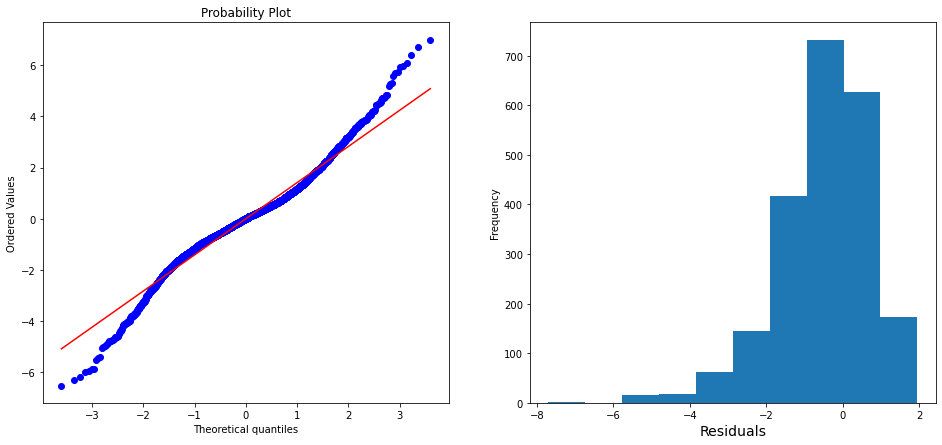

In [33]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

## Question 7

Проверьте критерием Бройша-Пагана гомоскедастичность ошибки в построенной модели. Выполняется ли она?

Если ошибка гетероскедастична, перенастройте модель, сделав поправку Уайта типа HC1. 

In [35]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000000


*ошибка гетероскедастична - делаем поправку*

In [40]:
m1_1 = smf.ols(features, 
             data=df)
fitted = m1.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     345.0
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:16:01   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

## Question 8

Удалите из модели незначимые признаки religion, radio и tv. Проверьте гомоскедастичность ошибки, при необходимости сделайте поправку Уайта. 

Не произошло ли значимого ухудшения модели после удаления этой группы признаков? Проверьте с помощью критерия Фишера. Чему равен его достигаемый уровень значимости? Округлите до четырёх цифр после десятичной точки.

Если достигаемый уровень значимости получился маленький, верните все удалённые признаки; если он достаточно велик, оставьте модель без религии, тв и радио.

In [36]:
features_2 = 'ceb ~ age + educ + idlnchld + knowmeth + usemeth + agefm + heduc + urban + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans'

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     559.5
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:14:38   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.198     -5.

d:\programs\anaconda3\envs\sci\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


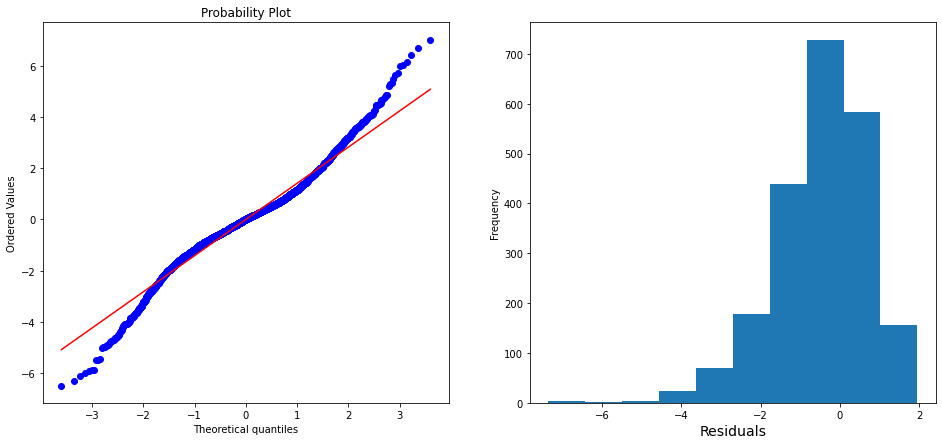

In [37]:
m2 = smf.ols(features_2, 
             data=df)
fitted = m2.fit() #(cov_type='HC1')
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

In [38]:
print("F=%f, p=%.4f, k1=%f" % m1.fit().compare_f_test(m2.fit()))

F=0.919236, p=0.4672, k1=5.000000


поправка Уайта

In [39]:
m3 = smf.ols(features_2, 
             data=df)
fitted = m3.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:14:49   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.

## Question 9

Признак usemeth_noans значим по критерию Стьюдента, то есть, при его удалении модель значимо ухудшится. Но вообще-то отдельно его удалять нельзя: из-за того, что мы перекодировали пропуски в usemeth произвольно выбранным значением cusemeth=−1c_{usemeth }=-1cusemeth​=−1, удалять usemeth_noans и usemeth можно только вместе.

Удалите из текущей модели usemeth_noans и usemeth. Проверьте критерием Фишера гипотезу о том, что качество модели не ухудшилось. Введите номер первой значащей цифры в достигаемом уровне значимости (например, если вы получили 5.5×10−85.5\times10^{-8}5.5×10−8, нужно ввести 8).

Если достигаемый уровень значимости получился маленький, верните удалённые признаки; если он достаточно велик, оставьте модель без usemeth и usemeth_noans.  

In [41]:
features_3 = 'ceb ~ age + educ + idlnchld + knowmeth + agefm + heduc + urban + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans'

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     611.3
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:16:47   Log-Likelihood:                -7825.7
No. Observations:                4348   AIC:                         1.568e+04
Df Residuals:                    4335   BIC:                         1.576e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1931      0.202     -5.

d:\programs\anaconda3\envs\sci\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


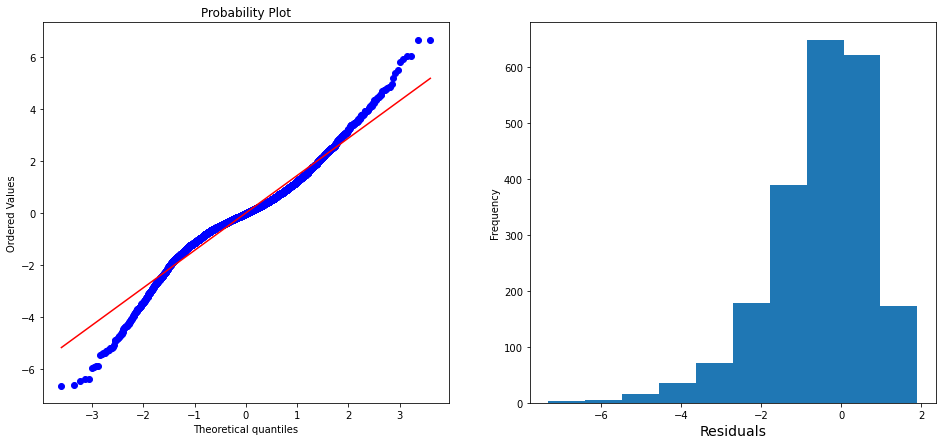

In [42]:
m4 = smf.ols(features_3, 
             data=df)
fitted = m4.fit()#(cov_type='HC1')
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

In [44]:
print("F=%f, p=%.40f, k1=%f" % m3.fit().compare_f_test(m4.fit()))

F=92.890582, p=0.0000000000000000000000000000000000000003, k1=2.000000


## Question 10
Посмотрите на доверительные интервалы для коэффициентов итоговой модели (не забудьте использовать поправку Уайта, если есть гетероскедастичность ошибки) и выберите правильные выводы.

* У женщин, не знающих, какое количество детей идеально (idlnchld), в среднем на 0.66 ребёнка больше (p=0.002, 95% доверительный интервал — [0.2, 1.1])
No: 0.055       0.098

* У женщин, знакомых с методами контрацепции, при прочих равных в среднем на 0.6 ребёнка меньше (p=0.001, 95% доверительный интервал для разницы между средними — [-0.9, -0.2])
No: p= 0.8352, [0.588, 1.082]

* С увеличением возраста женщины на 1 год среднее количество детей возрастает на 0.17 (p<0.001, 95% доверительный интервал — [0.16, 0.18])
Yes: 0.1762; 0.170       0.183

* У женщин, никогда не выходивших замуж, при прочих равных в среднем на 2.3 ребёнка меньше (p<0.001, 95% доверительный интервал для разницы между средними — [-2.6, -1.9])
Yes: [-2.627, -2.019]

* Итоговая модель объясняет 63% вариации отклика
Yes: R^2=0.634

* У женщин, не знающих, какое количество детей идеально, в среднем на βidlnchld_noans+cidlnchldβidlnchld≈0.58\beta_{idlnchld\_noans} + c_{idlnchld} \beta_{idlnchld} \approx 0.58 βidlnchld_noans​+cidlnchld​βidlnchld​≈0.58 детей больше

In [45]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     611.3
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:17:00   Log-Likelihood:                -7825.7
No. Observations:                4348   AIC:                         1.568e+04
Df Residuals:                    4335   BIC:                         1.576e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1931      0.202     -5.

С увеличением возраста женщины на 1 год среднее количество детей возрастает на 0.17 (p<0.001, 95% доверительный интервал — [0.16, 0.18])

Итоговая модель объясняет 63% вариации отклика

У женщин, никогда не выходивших замуж, при прочих равных в среднем на 2.3 ребёнка меньше (p<0.001, 95% доверительный интервал для разницы между средними — [-2.6, -1.9])